Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---

# Permutation & Boosting

- Get **permutation importances** for model interpretation and feature selection
- Use xgboost for **gradient boosting**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- matplotlib
- numpy
- pandas
- scikit-learn
- [**xgboost**](https://xgboost.readthedocs.io/en/latest/)

# I. Wrangle Data

## Import

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OrdinalEncoder
from numpy.random import permutation

from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier

In [14]:
DATA_PATH = '../data/'

We'll go back to Tanzania Waterpumps for this lesson.

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
              pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X = X.drop(columns='date_recorded')
    
    # return the wrangled dataframe
    return X

In [16]:
# Arrange data into X features matrix and y target vector
df = wrangle(df)

# II. Split Data

In [17]:
# Split our feature matrix and target vector
y = df['status_group']
X = df.drop('status_group', axis=1)

In [18]:
# Train-validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

In [19]:
print('Baseline Accuracy Score:', y_train.value_counts(normalize=True).max())

Baseline Accuracy Score: 0.5425829668132747


# IV. Build Model

In [23]:
model_rf = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(strategy='median'),
                        RandomForestClassifier(random_state=42))
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
other                          3
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'wa

In [24]:
print('base model accuracy is', model_rf.score(X_val, y_val))

base model accuracy is 0.8090909090909091


### Ensemble learning
* 1. bootstrap
* 2. boosting
   - a. combine weak learners into a strong learner.
   - b. not work parallel, train predictors sequentially, correct its predecessor.
   - c. not use the subset data, but use all the data to train your model

In [28]:
model_gb = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(strategy='median'),
                        GradientBoostingClassifier(learning_rate=0.1, n_estimators=150, random_state=42))
model_gb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
           

In [27]:
print('gradient boosting model accuracy is', model_gb.score(X_val, y_val))

gradient boosting model accuracy is 0.7560606060606061


In [29]:
model_xg = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(strategy='median'),
                        XGBClassifier(random_state=42, n_jobs=10))
model_xg.fit(X_train, y_train)

/Users/sisichen/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:26:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan

In [31]:
model_xg

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan

In [30]:
print('XGBoosting model accuracy is', model_xg.score(X_val, y_val))

XGBoosting model accuracy is 0.7914983164983165


# V. Check Metrics

# Communicate Results

### 1. Feature Importances

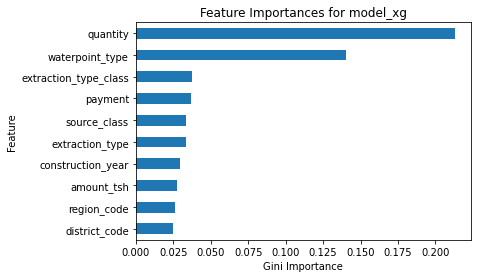

In [33]:
importances = model_xg.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for model_xg');

### 2. Permutation Importance

In [34]:
perm_imp = permutation_importance(model_xg,
                                  X_val, 
                                  y_val, 
                                  n_jobs=10, 
                                  random_state=42)

In [36]:
perm_imp['importances_mean']

array([ 4.66329966e-03,  7.18855219e-03,  9.41077441e-03,  4.25925926e-03,
        1.41414141e-02,  1.50336700e-02,  1.22895623e-03, -1.01010101e-04,
        1.46464646e-03,  1.04377104e-03,  5.11784512e-03,  1.75084175e-03,
        4.04040404e-03,  1.02356902e-02,  5.94276094e-03,  1.35858586e-02,
        2.25589226e-03,  3.13131313e-03,  5.52188552e-03,  2.97979798e-03,
        2.05723906e-02,  1.02525253e-02,  6.73400673e-05,  6.91919192e-03,
        3.33333333e-03,  5.05050505e-05,  1.31986532e-02,  2.15488215e-03,
        0.00000000e+00,  1.03468013e-01,  5.85858586e-03,  8.24915825e-04,
        1.06060606e-03,  3.17845118e-02,  1.16161616e-03,  3.19865320e-04,
        1.41414141e-03])

In [41]:
data = pd.DataFrame({'importances_mean': perm_imp['importances_mean']}, index = X_val.columns)

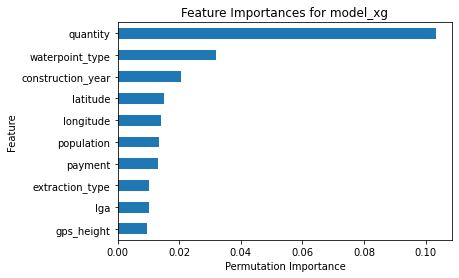

In [43]:
data['importances_mean'].sort_values().tail(10).plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for model_xg');